In [1]:
import sys
sys.path.insert(0,'../../../ece219-project3')

from project3.utils.DataIO import DataIO
io = DataIO("../data")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.display import display, HTML

In [2]:
# Silences warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
from project3.utils.MslrWeb10kDataset import MslrWeb10kDataset
web10k_data = MslrWeb10kDataset()
web10k_fold1 = web10k_data.load_one_fold("../data/Fold1/")
web10k_fold2 = web10k_data.load_one_fold("../data/Fold2/")
web10k_fold3 = web10k_data.load_one_fold("../data/Fold3/")
web10k_fold4 = web10k_data.load_one_fold("../data/Fold4/")
web10k_fold5 = web10k_data.load_one_fold("../data/Fold5/")

In [4]:
folds = [
    web10k_fold1,
    web10k_fold2,
    web10k_fold3,
    web10k_fold4,
    web10k_fold5
]

In [5]:
X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = [i for i in range(8)]

In [6]:
unique_qid = lambda fold: len(np.unique(np.concatenate([fold[qid_test], fold[qid_train]])))

In [7]:
unique_qid(web10k_fold1)

8000

In [8]:
import matplotlib.pyplot as plt
def distribution_relevance(fold):
    rel_labels = np.concatenate([fold[y_train], fold[y_test]])
    unique, counts = np.unique(rel_labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel("Relevance Label")
    plt.ylabel("Occurrences")
    plt.title("Distribution of Relevance Labels")

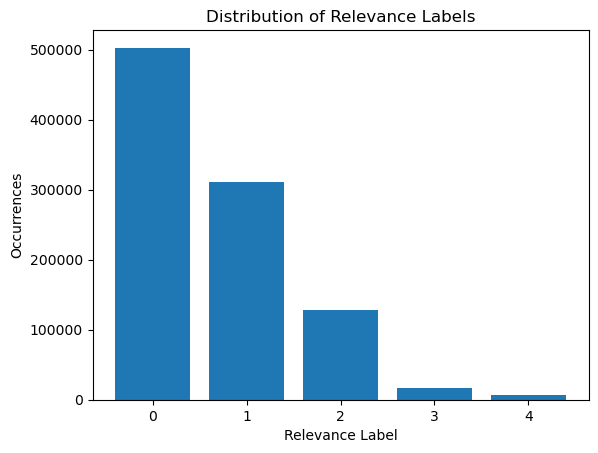

In [9]:
distribution_relevance(web10k_fold1)

In [10]:
import lightgbm
def fit_and_score(x_tr, y_tr, g_tr, x_te, y_te, q_te):
    model = lightgbm.LGBMModel(objective='lambdarank', n_jobs=-2)
    model.fit(X=x_tr, y=y_tr, group=g_tr)
    clear_output()
    ndcg3 = web10k_data.compute_ndcg_all(model, x_te, y_te, q_te, k=3)
    ndcg5 = web10k_data.compute_ndcg_all(model, x_te, y_te, q_te, k=5)
    ndcg10 = web10k_data.compute_ndcg_all(model, x_te, y_te, q_te, k=10)
    ndcg_ = [ndcg3, ndcg5, ndcg10]
    return model, ndcg_

def remove_features(train, test, df: pd.DataFrame):
    feat_columns = df['feat_column'].values
    total_feats = train.shape[1]
    to_keep = list(set(range(total_feats)) - set(feat_columns))
    altered_train = train[:, to_keep]
    altered_test = test[:, to_keep]
    return altered_train, altered_test

def process_fold(fold):
    model, ndcg_ = fit_and_score(fold[X_train], fold[y_train], fold[group_train], fold[X_test], fold[y_test], fold[qid_test])
    feature_importance = web10k_data.get_feature_importance(model)
    feature_names = [int(i.split("_")[1]) for i in model.booster_.feature_name()]
    imp_df = pd.DataFrame({"feat_column": feature_names, "feat_importance": feature_importance}).sort_values("feat_importance", ascending=False).reset_index(drop=True)
    top_5 = imp_df.head(5)
    top_20 = imp_df.head(20)
    bottom_60 = imp_df.tail(60)
    no_top_20_train, no_top_20_test = remove_features(fold[X_train], fold[X_test], top_20)
    _, no_top_20_ndcg_ = fit_and_score(no_top_20_train, fold[y_train], fold[group_train], no_top_20_test, fold[y_test], fold[qid_test])
    no_bottom_60_train, no_bottom_60_test = remove_features(fold[X_train], fold[X_test], bottom_60)
    _, no_bottom_60_ndcg_ = fit_and_score(no_bottom_60_train, fold[y_train], fold[group_train], no_bottom_60_test, fold[y_test], fold[qid_test])
    display(HTML(top_5.to_html()))
    ndcg_dict = {
        "All Features": ndcg_,
        "W/O Top 20 Features": no_top_20_ndcg_,
        "W/O Bottom 60 Features": no_bottom_60_ndcg_
    }
    ndcg_df = pd.DataFrame(ndcg_dict, index=["nDCG@3", "nDCG@5", "nDCG@10"])
    display(HTML(ndcg_df.to_html()))

In [11]:
process_fold(web10k_fold1)

,feat_column,feat_importance
0,133,23856.702951
1,7,4248.546391
2,107,4135.244450
3,54,4078.463216
4,129,3635.037024


,All Features,W/O Top 20 Features,W/O Bottom 60 Features
nDCG@3,0.456457,0.379675,0.454253
nDCG@5,0.463289,0.385030,0.462657
nDCG@10,0.482867,0.408364,0.481971


In [12]:
process_fold(web10k_fold2)

,feat_column,feat_importance
0,133,23578.908250
1,7,5157.964912
2,54,4386.669757
3,107,4094.012172
4,129,4035.070673


,All Features,W/O Top 20 Features,W/O Bottom 60 Features
nDCG@3,0.453890,0.373945,0.457290
nDCG@5,0.457329,0.381954,0.460267
nDCG@10,0.476755,0.404503,0.477253


In [13]:
process_fold(web10k_fold3)

,feat_column,feat_importance
0,133,23218.075441
1,54,4991.303372
2,107,4226.807395
3,129,4059.752514
4,7,3691.792320


,All Features,W/O Top 20 Features,W/O Bottom 60 Features
nDCG@3,0.449068,0.382383,0.449790
nDCG@5,0.458348,0.389996,0.458640
nDCG@10,0.475895,0.411636,0.477436


In [14]:
process_fold(web10k_fold4)

,feat_column,feat_importance
0,133,23796.899673
1,7,4622.622978
2,54,3883.481706
3,129,3356.846980
4,128,3207.575537


,All Features,W/O Top 20 Features,W/O Bottom 60 Features
nDCG@3,0.461179,0.381977,0.460635
nDCG@5,0.466386,0.392810,0.467340
nDCG@10,0.487725,0.412107,0.488881


In [15]:
process_fold(web10k_fold5)

,feat_column,feat_importance
0,133,23540.942354
1,7,4794.945172
2,54,4079.608554
3,107,3514.835752
4,129,3209.058444


,All Features,W/O Top 20 Features,W/O Bottom 60 Features
nDCG@3,0.469634,0.384283,0.470186
nDCG@5,0.471432,0.392168,0.473352
nDCG@10,0.490359,0.416687,0.490817
